# Logistic Regression

Today we will start working on our first Machine Learning model: Linear Regression.

### Import libraries

In [2]:
# First, we import the libraries we will use in this notebook and load the Fragile Families data. 
# The first line sets maplotlib plots to show inside the notebook.
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
import sys
sys.path.append('..')
import ff

In [3]:
# Read in data
background = "../../ai4all_data/background.csv"
train = "../../ai4all_data/train.csv"

# Read in data
data_frame = pd.read_csv(background, low_memory=False)
data_frame = data_frame.set_index('challengeID')

# outcome variables
outcome = pd.read_csv(train, low_memory=False)
outcome = outcome.set_index('challengeID')

## Logistic Regression

Logistic regression models the relationship between a binary outcome $Y$ that can be either 1 or 0 and a predictor $X$. The main difference between logistic regression and linear and multiple linear regression is that the resulting model is not linear (it is not a line but a curve) and that it does not predict the value of the outcome $Y$ but instead it predicts the probability that $Y$ is equal to 1.

As in linear regression, we plot the data on a scatter plot and then compute the best-fit curve through the data points using the following equation which takes into account that $Y$ is a binary variable:

$$ \frac{p(Y)}{1-p(Y)} = c_0 + c_1 X + \epsilon$$

where $p(Y)$ is the probability that $Y=1, $$c_0$ is the regression coefficient associated with the probability that $Y=1$ when $X=0$, and $c_1$ is the regression coefficient that tells us how much the probability that $Y=1$ changes when the predictor $X$ is not zero. As before, we will set $\epsilon$ to zero, meaning we will ignore the effects of noise.

The best-fit curve provides a nonlinear model which allows us to make predictions about the probability that $Y=1$ or $Y=0$ given the value of $X$.

In this section we will build a logistic regression model to predict layoff. For the predictor $X$, we will use information about whether the mother had "done regular work for pay last week" in wave 5 (when the child was ~9 years old) (feature m5i4).

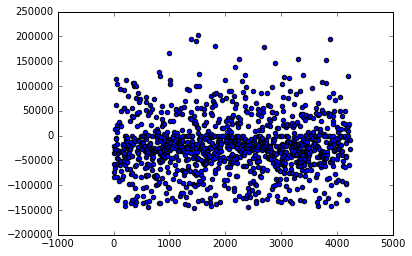

In [307]:
# Choose only those rows of data_frame that are left in outcome
rows_remaining_outcome = outcome.index.values
rows_to_keep_dataframe = data_frame.index.isin(rows_remaining_outcome)
data_frame = data_frame.loc[rows_to_keep_dataframe]

# subselect the column we are interested in
#mom_work = data_frame[['m5i4','m5a2','f5i4','f5a2']]

# print info about features
# note that there are some entries that 
#print(ff.select('cp3food_exp'))

# Feature Engineering. Create new feature that we believe is predictive of eviction. To do this we will combine 
# financial information about the father and the mother and whether they live together when the child is 9 years old.
# We will use features cm5hhinc (father's household income), cf5hhinc (mother's household income), and 
# cf5cohm (do they cohabitate?)

# For couples that cohabitate, we will average the household income
income_coh = (data_frame.cm5hhinc*0.5 + data_frame.cf5hhinc*0.5)*data_frame.cf5cohm 
# For couples that do not cohabitate, we will do a weighted average of the household incomes
# where we give a higher weight to the mother's income
income_notcoh = (data_frame.cm5hhinc*0.75 + data_frame.cf5hhinc*0.25)*(~data_frame.cf5cohm)
# Now we sum them up to get one feature that we can use in the logistic regression
income = income_coh + income_notcoh
#expenses = data_frame.ih4_k2_expen #(data_frame.cp4k2_expen+data_frame.cp4k4_expen+data_frame.cp4k5_expen)
income = pd.DataFrame(income,columns=['Income'])
plt.scatter(income.index,income)

# Note that negative entries mean that there is no info about whether the parents cohabitate

In [308]:
# Impute values. For now, we will remove all values that are negative
X = income[income>0]
X.dropna(inplace=True)
Y = outcome.loc[outcome.index.isin(X.index.values)]
#picks out layoff
eviction = Y.eviction
# remove NaN entries in layoff
eviction = eviction[~np.isnan(eviction)]
# match columns with X
X = X.loc[eviction.index]
#make sure the the number of rows are the same
print(X.shape)
print(eviction.shape)

(330, 1)
(330,)


In [309]:
# Split our data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, eviction, test_size = 0.3, random_state = 100)

print(X_train.shape)
print(y_train.shape)

(231, 1)
(231,)


slope : [[ -4.52706208e-05]]
intercept : [ -4.45227129e-09]


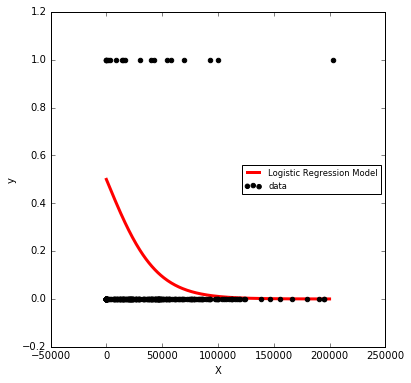

In [310]:
from sklearn import linear_model
# fit the linear regression model and get the slope and intercept
reg = linear_model.LogisticRegression()

reg.fit(X_train,y_train)

print('slope : {}'.format(reg.coef_))
print('intercept : {}'.format(reg.intercept_))

# and plot the result
plt.figure(1, figsize=(6, 6))
plt.clf()
plt.scatter(X_train, y_train, color='black', zorder=20)
linspace = np.linspace(-5, 200000, 300)

def model(x):
    return 1 / (1 + np.exp(-x))

loss = model(linspace * reg.coef_ + reg.intercept_)
plt.plot(linspace, loss.ravel(), color='red', linewidth=3)
plt.ylabel('y')
plt.xlabel('X')
#plt.xticks(range(-5, 10))
#plt.yticks([0, 0.5, 1])
#plt.ylim(-.25, 1.25)
#plt.xlim(-4, 10)
plt.legend(('Logistic Regression Model','data'),
           loc="center right", fontsize='small')
plt.show()

## Multiple Logistic Regression

Multiple logistic regression models is the generalization of logistic regression to multiple predictors. That is, multiple logistic regression models the relationship between a binary outcome $Y$ that can be either 1 or 0 and multiple predictors $X_i$. 

The model is given by the equation

$$ \frac{p(Y)}{1-p(Y)} = c_0 + c_1 X_1 + c_2 X_2 + c_3 X_3 + \dots + c_n X_n + \epsilon$$

where $p(Y)$ is the probability that $Y=1, $$c_0$ is the regression coefficient associated with the probability that $Y=1$ when $X_i=0$ for all $i$, and $c_i$ is the regression coefficient that tells us how much the probability that $Y=1$ changes when the predictor $X_i$ is not zero. As before, we will set $\epsilon$ to zero, meaning we will ignore the effects of noise.

The best-fit curve provides a nonlinear model which allows us to make predictions about the probability that $Y=1$ or $Y=0$ given the values of $X_i$.

In this section we will build a multiple logistic regression model to predict eviction. For the predictor $X$ predictor, we will use SOMETHING (feature XXXXXXX) and SOMETHING2 (feature XXXX2).

In [301]:
from sklearn.preprocessing import OneHotEncoder
# subselect the column we are interested in
features = data_frame[['m5i4','m5f23d','f5i4','f5f23d']]
features['m5i4'] = features.m5i4.astype(str)
features['m5f23d'] = features.m5i4.astype(str)
features['f5i4'] = features.m5i4.astype(str)
features['f5f23d'] = features.m5i4.astype(str)
X = pd.get_dummies(features)

C:\Users\Renato\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Renato\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Renato\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

In [303]:
X = X.loc[eviction.index]
#make sure the the number of rows are the same
print(X.shape)
print(eviction.shape)
# Split our data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, eviction, test_size = 0.3, random_state = 100)

(330, 20)
(330,)
